In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as ds
#ds.download('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

In [ ]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch import nn, optim
import matplotlib.pyplot as plt

In [ ]:
# Function to explore and visualize dataset
def explore_dataset(dataset_path):
    classes = os.listdir(dataset_path)
    num_classes = len(classes)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {classes}")

    # Optional: Visualize some images from each class
    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    for i, cls in enumerate(classes):
        image_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        image = plt.imread(image_path)
        axes[i].imshow(image)
        axes[i].set_title(cls)
        axes[i].axis('off')
    plt.show()




In [ ]:
# Function to print model information
def print_model_info(model):
    print("Model Summary:\n")
    for name, layer in model.named_modules():
        print(f"{name} : {layer.__class__.__name__}")

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {trainable_params}")

In [ ]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
model.fc = nn.Linear(512, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# Print model information
print_model_info(model)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']


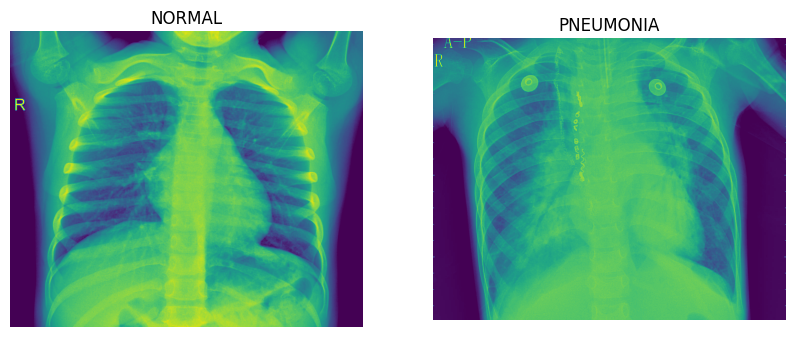

Number of classes: 2
Classes: ['NORMAL', 'PNEUMONIA']


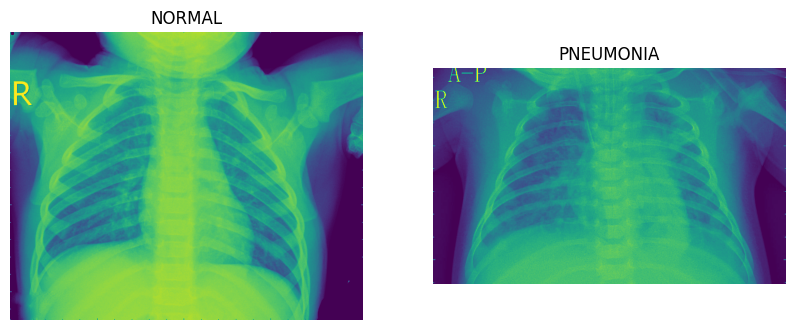

In [ ]:
import os
# Explore and visualize the datasets
path_to_train_dataset = '/content/chest-xray-pneumonia/chest_xray/train'
path_to_val_dataset = '/content/chest-xray-pneumonia/chest_xray/val'
explore_dataset(path_to_train_dataset)
explore_dataset(path_to_val_dataset)

In [ ]:
# Load the dataset
train_dataset = ImageFolder(root=path_to_train_dataset, transform=transform)
val_dataset = ImageFolder(root=path_to_val_dataset, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Set up the device for GPU training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

In [ ]:
# Number of epochs
num_epochs = 10  # Adjust as needed

In [ ]:
# Train the model
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 0.0676, Accuracy: 68.75%
Epoch [2/10], Loss: 0.2882, Accuracy: 75.00%
Epoch [3/10], Loss: 0.1081, Accuracy: 75.00%
Epoch [4/10], Loss: 0.1459, Accuracy: 62.50%
Epoch [5/10], Loss: 0.1598, Accuracy: 75.00%
Epoch [6/10], Loss: 0.1653, Accuracy: 62.50%
Epoch [7/10], Loss: 0.1831, Accuracy: 81.25%
Epoch [8/10], Loss: 0.1099, Accuracy: 81.25%
Epoch [9/10], Loss: 0.1440, Accuracy: 62.50%
Epoch [10/10], Loss: 0.1411, Accuracy: 81.25%


In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), 'resnet18_model.pth')

Inference

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
# Function to load and process image
def process_image(image_path, transform):
    img = Image.open(image_path)
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

# Load the model architecture
model = models.resnet18()
model.fc = nn.Linear(512, 2)  # Make sure this matches your model's last layer

# Load the trained model weights
model.load_state_dict(torch.load('resnet18_model.pth'))

# Set model to evaluation mode
model.eval()

# Assume you have a CUDA-enabled GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inference on a new image
image_path = 'path_to_your_image.jpg'  # Replace with your image path
image = process_image(image_path, transform)
image = image.to(device)  # Move image tensor to the same device as the model

# Perform inference
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    print(f'Predicted Class: {predicted.item()}')

### Brain-Tumor-Classification 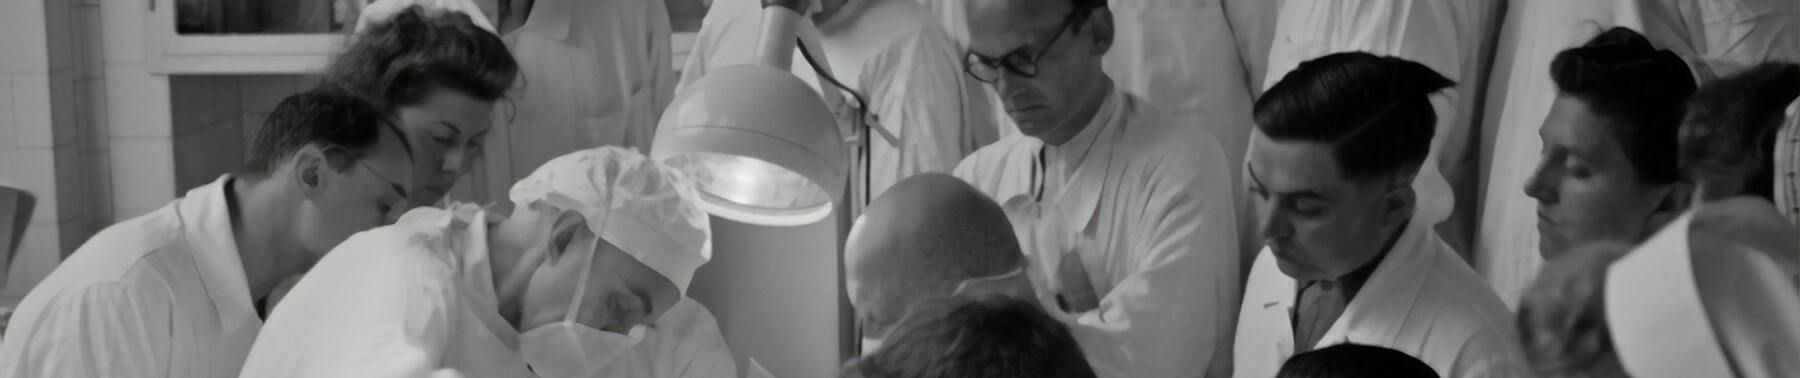

In [ ]:
import opendatasets as ds
ds.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anandtrivedi
Your Kaggle Key: ··········


100%|██████████| 149M/149M [00:08<00:00, 19.2MB/s]


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image


In [ ]:
from torchvision.datasets import ImageFolder


# Modify the data transformation for grayscale images
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Use single value for mean and std
])

train_dataset = ImageFolder('/content/brain-tumor-mri-dataset/Training', transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder('/content/brain-tumor-mri-dataset/Testing', transform=transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [ ]:
num_classes=len(train_dataset.classes)

In [ ]:
!pip install efficientnet-pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')  # Using EfficientNet-B0
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')


Epoch [1/10], Loss: 0.2934104290057798
Epoch [2/10], Loss: 0.15532469560838297
Epoch [3/10], Loss: 0.09824830071259738
Epoch [5/10], Loss: 0.05295346659991834
Epoch [6/10], Loss: 0.055266443198626336
Epoch [7/10], Loss: 0.07477022517415113
Epoch [8/10], Loss: 0.04226674738663564
Epoch [9/10], Loss: 0.050019424901360514
Epoch [10/10], Loss: 0.04796728096419426


In [ ]:
#training with accuracy track to track accuracy graph

num_epochs = 10
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Training Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')



Epoch 1/10, Loss: 0.2517322715132513, Training Accuracy: 91.5266106442577%, Test Accuracy: 95.4233409610984%
Epoch 2/10, Loss: 0.1043388692690736, Training Accuracy: 96.32352941176471%, Test Accuracy: 93.66895499618612%
Epoch 3/10, Loss: 0.07514889118347483, Training Accuracy: 97.39145658263305%, Test Accuracy: 96.10983981693364%
Epoch 4/10, Loss: 0.06674426621770455, Training Accuracy: 97.7766106442577%, Test Accuracy: 95.4233409610984%
Epoch 5/10, Loss: 0.037742896285655976, Training Accuracy: 98.7219887955182%, Test Accuracy: 98.8558352402746%
Epoch 6/10, Loss: 0.048602084629400244, Training Accuracy: 98.56442577030812%, Test Accuracy: 94.50800915331808%
Epoch 7/10, Loss: 0.0723200930964056, Training Accuracy: 97.88165266106442%, Test Accuracy: 98.01678108314263%
Epoch 8/10, Loss: 0.04096883157848292, Training Accuracy: 98.59943977591037%, Test Accuracy: 98.62700228832952%
Epoch 9/10, Loss: 0.01633395603439262, Training Accuracy: 99.43977591036415%, Test Accuracy: 98.62700228832952%

Accuracy: 99.31350114416476%


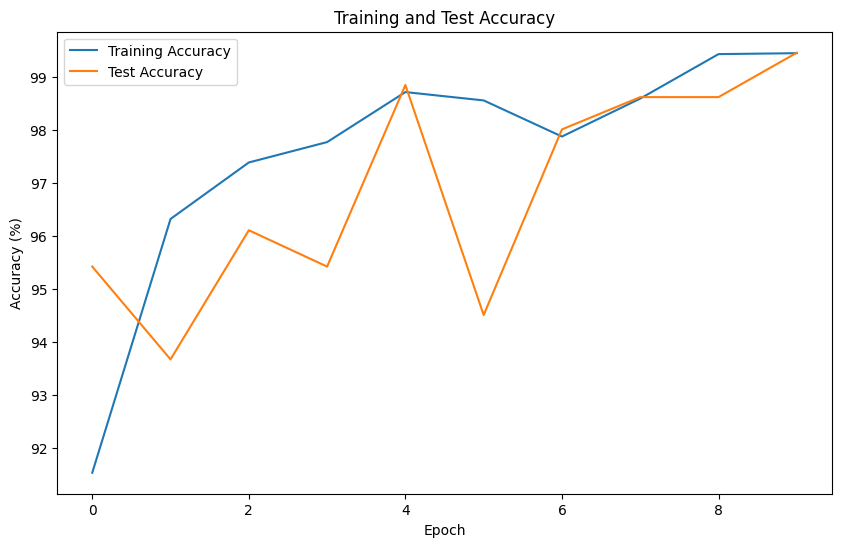

In [ ]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100}%')

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


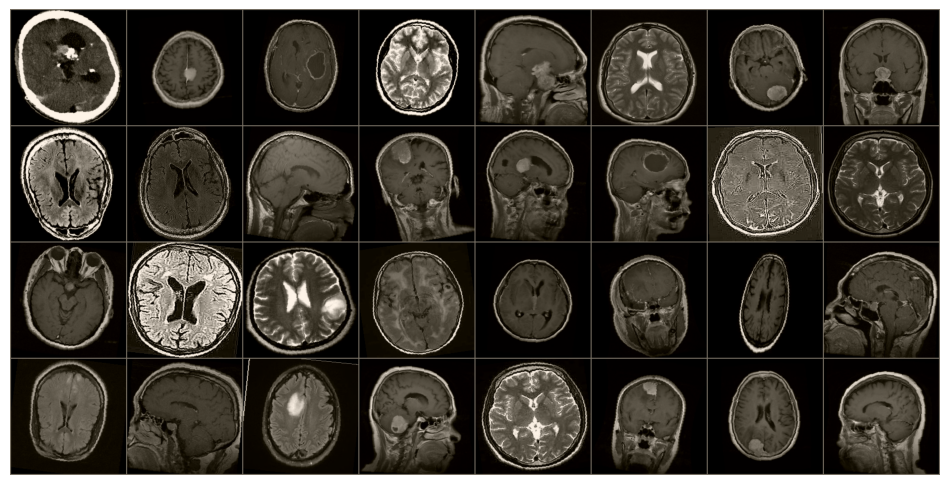

In [ ]:
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img, figsize=(12, 12)):
    img = img.numpy().transpose((1, 2, 0))  # convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = make_grid(inputs, nrow=8)  # Adjust nrow to change images per row

imshow(out)

Saving complete Model

In [ ]:
# Save the entire model
torch.save(model, 'model_complete.pth')

# To load the model later
model = torch.load('model_complete.pth')
model.eval()  # Don't forget to call eval() for inference

Saving Only the State Dictionary

In [ ]:
# Save only the model state dictionary
torch.save(model.state_dict(), 'model_state_dict.pth')

# To load the model state dictionary later
# You must first create an instance of the model and then load the parameters
model = models.efficientnet_b0(pretrained=False)  # or your specific model architecture
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust for binary classification if needed

model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()  # Switch to evaluation mode


## Object Detection Visualization

Visualizing Feature Map

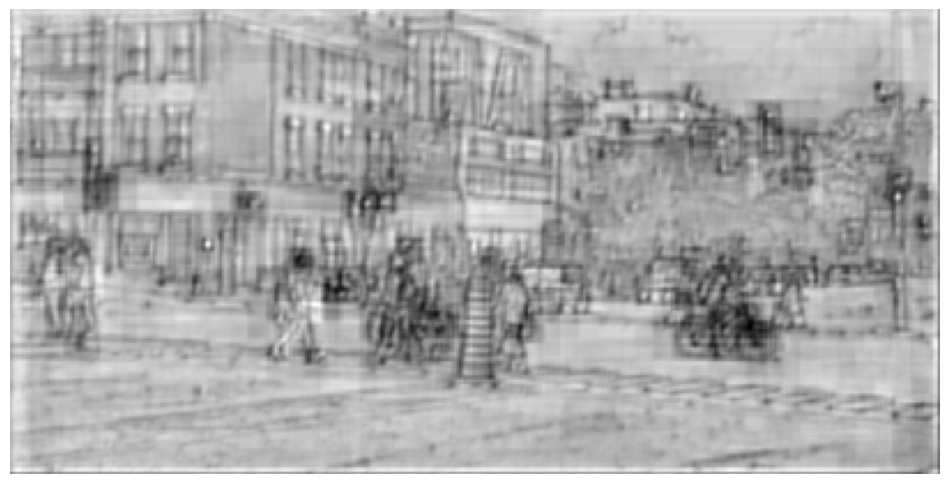

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load and preprocess an image
image_path = "/content/image1-1.png"
image = Image.open(image_path)
image_tensor = F.to_tensor(image).unsqueeze(0)

# Forward pass through the backbone
with torch.no_grad():
    features = model.backbone(image_tensor)

# Visualize one of the feature maps
feature_map = features['0'].squeeze(0)  # Selecting the first feature map
plt.figure(figsize=(12, 12))
plt.imshow(feature_map[0].cpu().numpy(), cmap='gray')  # Visualize the first channel
plt.axis('off')
plt.show()


Regional Proposals Generated BY RPN

1/1 [==============================] - 1s 908ms/step


1/1 [==============================] - 1s 884ms/step


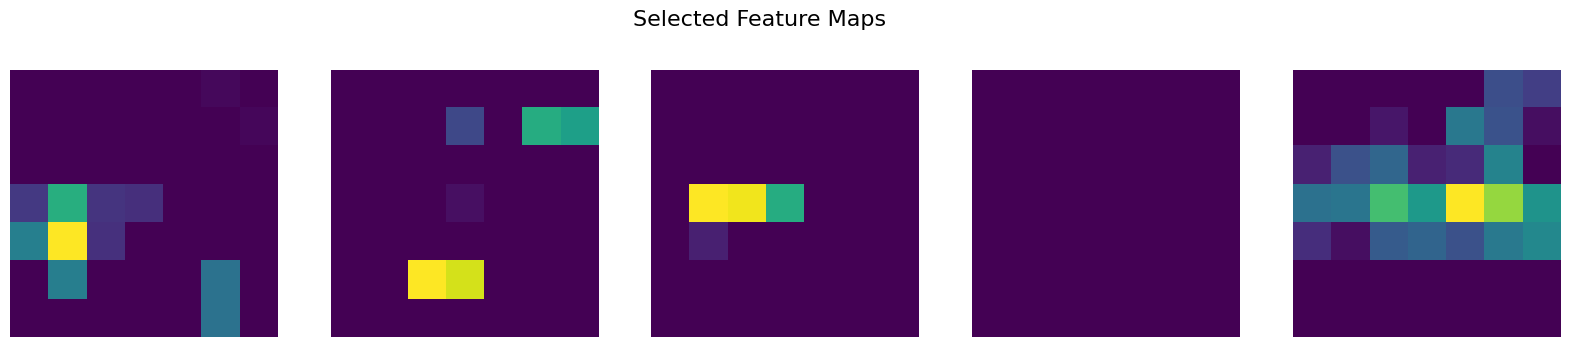

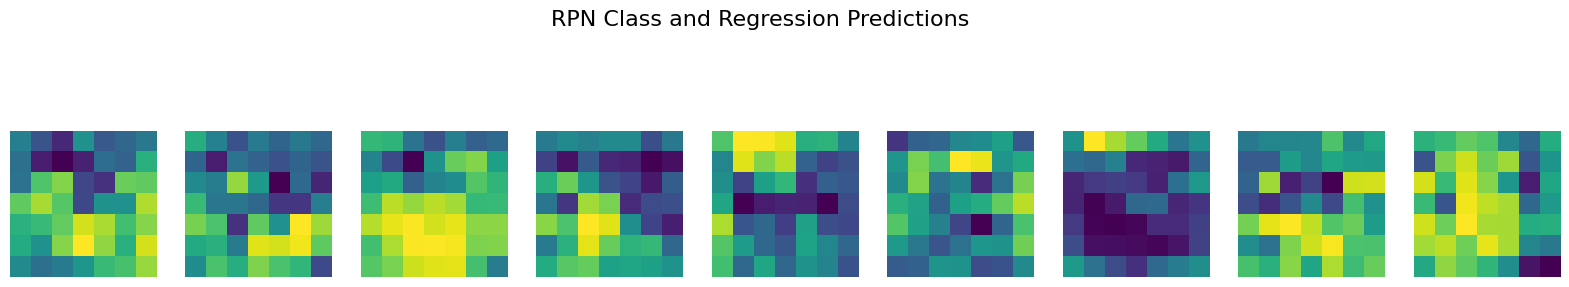

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model

# Load and preprocess an image
def load_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Feature extractor using MobileNetV2
def feature_extractor(inputs):
    feature_extractor = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')(inputs)
    return feature_extractor

# Regional Proposal Network (RPN)
def rpn_layer(base_layers, num_anchors):
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', name='rpn_out_regress')(x)
    return [x_class, x_regr]

# Model building
input_shape_img = (224, 224, 3)
num_anchors = 9

inputs_img = Input(shape=input_shape_img)
feature_map = feature_extractor(inputs_img)
rpn_class, rpn_regr = rpn_layer(feature_map, num_anchors)
model = Model(inputs=inputs_img, outputs=[rpn_class, rpn_regr])

# Intermediate model to get feature maps
feature_model = Model(inputs=inputs_img, outputs=feature_map)

# Load a real image
img_path = '/content/image1-1.png'  # Replace with your image path
input_image = load_preprocess_image(img_path)

# Predict using the real image
pred_class, pred_regr = model.predict(input_image)

# Visualize selected feature maps
def visualize_selected_feature_maps(image_data, num_maps=5):
    feature_maps = feature_model.predict(image_data)
    feature_maps = np.squeeze(feature_maps, axis=0)  # Remove batch dimension
    plt.figure(figsize=(20, 4))
    plt.suptitle("Selected Feature Maps", fontsize=16)
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(feature_maps[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

visualize_selected_feature_maps(input_image)

# Visualize RPN predictions
def visualize_rpn_predictions(pred_class, pred_regr, num_anchors=9):
    pred_class = np.squeeze(pred_class, axis=0)
    pred_regr = np.squeeze(pred_regr, axis=0)
    plt.figure(figsize=(20, 4))
    plt.suptitle("RPN Class and Regression Predictions", fontsize=16)
    for i in range(num_anchors):
        plt.subplot(1, num_anchors, i + 1)
        plt.imshow(pred_class[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

visualize_rpn_predictions(pred_class, pred_regr)


1/1 [==============================] - 0s 348ms/step


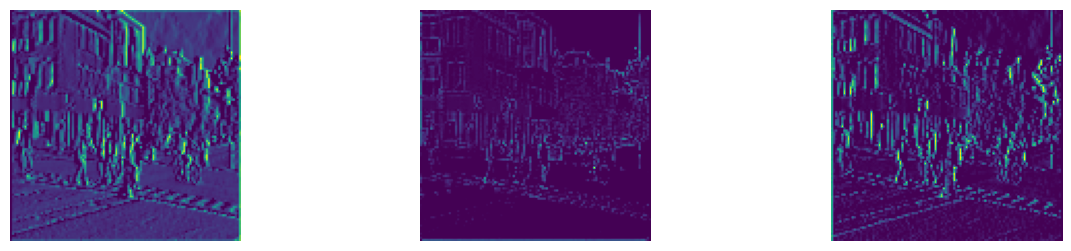

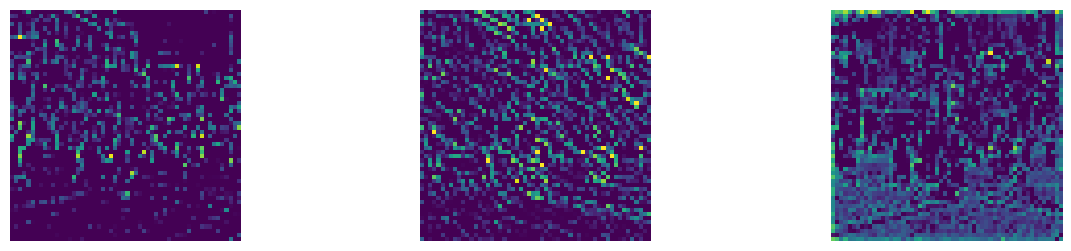

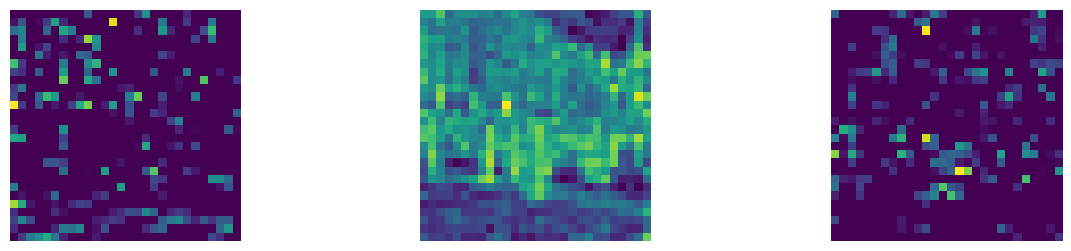

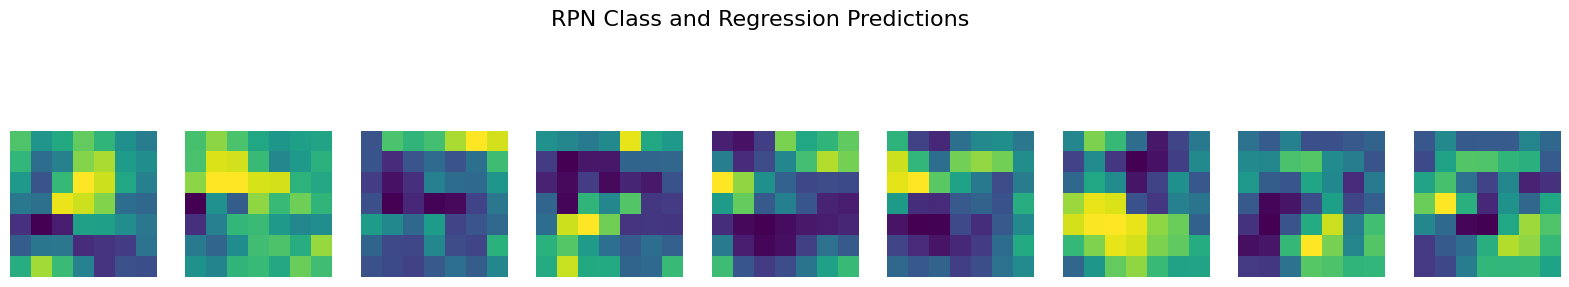

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model

# Load and preprocess an image
def load_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Feature extractor using MobileNetV2
def feature_extractor(inputs):
    feature_extractor = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')(inputs)
    return feature_extractor

# Regional Proposal Network (RPN)
def rpn_layer(base_layers, num_anchors):
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', name='rpn_out_regress')(x)
    return [x_class, x_regr]

# Model building
input_shape_img = (224, 224, 3)
num_anchors = 9
inputs_img = Input(shape=input_shape_img)

# Using full feature map for RPN
full_feature_map = feature_extractor(inputs_img)
rpn_class, rpn_regr = rpn_layer(full_feature_map, num_anchors)
full_model = Model(inputs=inputs_img, outputs=[rpn_class, rpn_regr])

# Extract early layers from MobileNetV2 for feature visualization
def early_layers_feature_extractor(inputs):
    model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    layer_names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu'] # Early layers
    layers_output = [model.get_layer(name).output for name in layer_names]
    return Model(inputs=model.input, outputs=layers_output)

# Early layers feature model
early_feature_map_model = early_layers_feature_extractor(inputs_img)

# Load a real image
img_path = '/content/image1-1.png'  # Replace with your image path
input_image = load_preprocess_image(img_path)

# Predict using the real image with the full model
pred_class, pred_regr = full_model.predict(input_image)

# Visualize feature maps from early layers
def visualize_early_feature_maps(image_data, feature_model):
    feature_maps = feature_model.predict(image_data)
    num_maps_per_layer = 3  # Number of feature maps to display per layer
    for layer_maps in feature_maps:
        layer_maps = np.squeeze(layer_maps, axis=0)
        fig, axs = plt.subplots(1, num_maps_per_layer, figsize=(15, 3))
        for i in range(num_maps_per_layer):
            axs[i].imshow(layer_maps[:, :, i], cmap='viridis')
            axs[i].axis('off')
        plt.show()

visualize_early_feature_maps(input_image, early_feature_map_model)

# Visualize RPN predictions
def visualize_rpn_predictions(pred_class, pred_regr, num_anchors=9):
    pred_class = np.squeeze(pred_class, axis=0)
    pred_regr = np.squeeze(pred_regr, axis=0)
    plt.figure(figsize=(20, 4))
    plt.suptitle("RPN Class and Regression Predictions", fontsize=16)
    for i in range(num_anchors):
        plt.subplot(1, num_anchors, i + 1)
        plt.imshow(pred_class[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

visualize_rpn_predictions(pred_class, pred_regr)


Pytorch script for visualization of internal working of object detection

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 51.3MB/s]


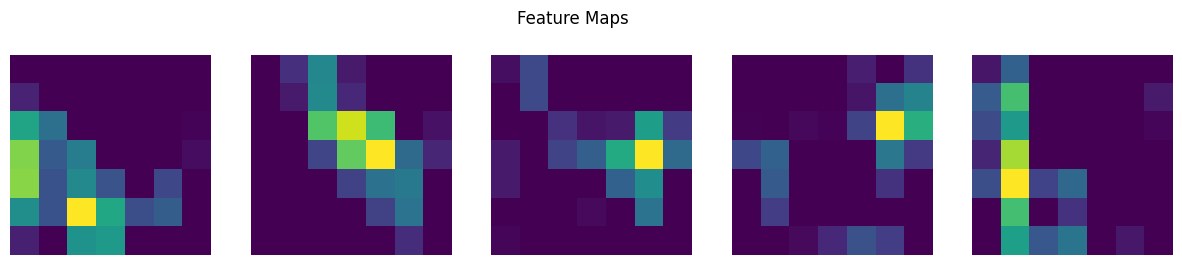

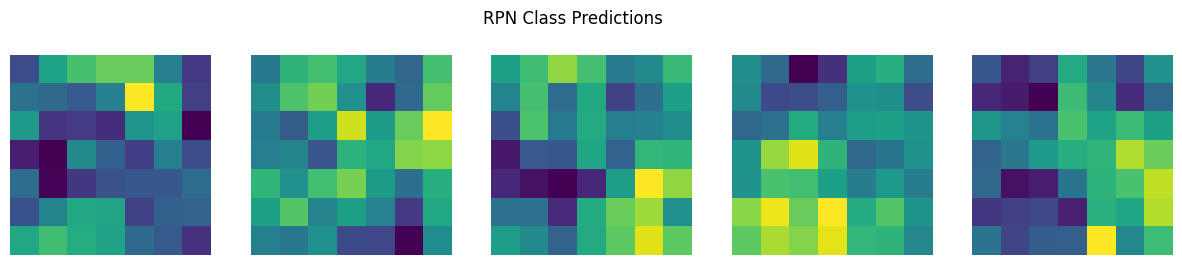

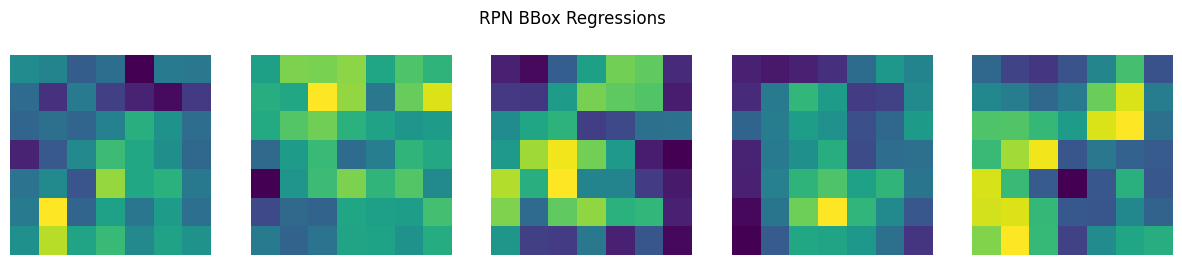

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn

# Load and preprocess an image
def load_preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

# Feature extractor using MobileNetV2
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        mobile_net = models.mobilenet_v2(pretrained=True)
        self.features = mobile_net.features

    def forward(self, x):
        x = self.features(x)
        return x

# Regional Proposal Network (RPN)
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.cls_conv = nn.Conv2d(256, num_anchors * 2, kernel_size=1) # 2 for obj or not obj
        self.reg_conv = nn.Conv2d(256, num_anchors * 4, kernel_size=1) # 4 for bbox deltas

    def forward(self, x):
        x = self.conv(x)
        cls_logits = self.cls_conv(x)
        bbox_pred = self.reg_conv(x)
        return cls_logits, bbox_pred

# Load a real image
img_path = '/content/image1-1.png'  # Replace with your image path
input_image = load_preprocess_image(img_path)

# Feature extraction
feature_extractor = FeatureExtractor()
feature_maps = feature_extractor(input_image)

# RPN
num_anchors = 9
rpn = RPN(in_channels=1280, num_anchors=num_anchors) # 1280 is the output channels of MobileNetV2
rpn_class, rpn_regr = rpn(feature_maps)

# Visualization function (for feature maps and RPN outputs)
def visualize_tensor(tensor, num_imgs=5, title=''):
    fig, axs = plt.subplots(1, num_imgs, figsize=(15, 3))
    tensor = tensor.detach().numpy()
    for i in range(num_imgs):
        axs[i].imshow(tensor[0, i, :, :], cmap='viridis')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize some feature maps
visualize_tensor(feature_maps, num_imgs=5, title='Feature Maps')

# Visualize some RPN predictions (classifications)
visualize_tensor(rpn_class, num_imgs=5, title='RPN Class Predictions')

# Visualize some RPN predictions (bbox regressions)
visualize_tensor(rpn_regr, num_imgs=5, title='RPN BBox Regressions')


### Marking Object Detections

In [ ]:
!pip install torch torchvision pillow


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn

# Function to apply object detection
def detect_objects(img_path, model, threshold=0.5):
    # Load the image
    image = Image.open(img_path).convert("RGB")
    image_tensor = T.ToTensor()(image)

    # Put the model in evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        prediction = model([image_tensor])

    # Draw the bounding boxes and labels on the image
    draw = ImageDraw.Draw(image)
    for element in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][element] > threshold:
            box = prediction[0]['boxes'][element].tolist()
            label = prediction[0]['labels'][element].tolist()
            score = prediction[0]['scores'][element].tolist()

            # Draw the box
            draw.rectangle(box, outline="red", width=3)
            # Optionally, add label and score
            draw.text((box[0], box[1]), f'{label}: {score:.2f}', fill="white")

    return image

# Load a pre-trained Faster R-CNN model with a MobileNet backbone
model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

# Path to your image
image_path = '/content/image1-1.png'

# Detect objects
result_image = detect_objects(image_path, model)

# Save or display the result
result_image.save("detected_objects.jpg")
# result_image.show()  # Uncomment to display the image


###Fast R-CNN on coco datasets

In [ ]:
!rm -rf voc_dataset_train

In [ ]:
!pip install opendatasets


In [ ]:
!rm -rf data

In [ ]:

# Label Mapping from VOC
LABEL_MAP = {
    'background': 0,  # Often, a background class is added
    'aeroplane': 1,
    'bicycle': 2,
    'bird': 3,
    'boat': 4,
    'bottle': 5,
    'bus': 6,
    'car': 7,
    'cat': 8,
    'chair': 9,
    'cow': 10,
    'diningtable': 11,
    'dog': 12,
    'horse': 13,
    'motorbike': 14,
    'person': 15,
    'pottedplant': 16,
    'sheep': 17,
    'sofa': 18,
    'train': 19,
    'tvmonitor': 20
}



100%|██████████| 1999639040/1999639040 [01:17<00:00, 25793968.63it/s]


Extracting ./data/VOC2012/VOCtrainval_11-May-2012.tar to ./data/VOC2012


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 85.9MB/s]


Epoch 1, Loss: 5.130392870259663
Epoch 2, Loss: 4.079691003239344
Epoch 3, Loss: 3.9930357734362283


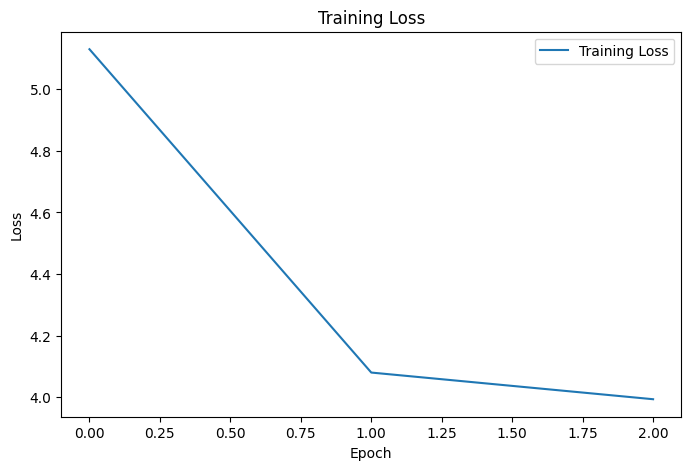

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Custom Dataset Class
class CustomVOCDataset(VOCDetection):
    def __init__(self, root, image_set, download, transform=None):
        super(CustomVOCDataset, self).__init__(root, year='2012', image_set=image_set, download=download)
        self.transform = transform

    def __getitem__(self, idx):
        img, target = super(CustomVOCDataset, self).__getitem__(idx)
        if self.transform:
            img = self.transform(img)

        # Convert labels from strings to integers
        annotations = target['annotation']['object']
        boxes = []
        labels = []

        if not isinstance(annotations, list):
            annotations = [annotations]

        for obj in annotations:
            bbox = obj['bndbox']
            boxes.append([int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])])
            labels.append(LABEL_MAP[obj['name']])  # Convert string labels to integers

        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)

        return img, target

# Transformation Function
def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])



# Custom Collate Function
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = torch.stack(images, dim=0)

    return images, targets

# Load Dataset
train_dataset = CustomVOCDataset(root='./data/VOC2012', image_set='train', download=True, transform=get_transform())
train_dataset = Subset(train_dataset, range(1000))  # Subset for demonstration
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Create the Fast R-CNN Model
def create_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = create_model(num_classes=21)  # Including background class
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
losses = []

for epoch in range(3):  # Number of epochs
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")
    losses.append(epoch_loss)

# Visualization of Training Loss
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
